# Regression - tutorial

This is a guided example that involves a regression problem - [abalone](https://archive.ics.uci.edu/ml/datasets/abalone) dataset.

## The plan
1. Import necessary packages.
2. Load and explore the dataset.
3. Perform data pre-processing (transformations, scaling, splitting).
4. Train and evaluate the models.
5. (optional) Hyperparameter optimisation.

## Step 1 - packages

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
def _trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_dist(data, bins=10, size=(12, 8)):
    sq = math.sqrt(data.shape[1])
    d_ceil = math.ceil(sq)
    d_floor = math.floor(sq)

    if (d_ceil * d_floor) >= data.shape[1]:
        n_rows = d_floor
        n_cols = d_ceil
    else:
        n_rows = n_cols = d_ceil

    fig, axs = plt.subplots(n_rows, n_cols, figsize=size)
    axs = _trim_axs(axs, data.shape[1])

    for i, ax in enumerate(axs):
        ax.hist(data[:, i], bins=bins)
    
    fig.tight_layout()
    plt.show()

## Step 2 - data

More information about the covariates:

| Name           | Data Type  | Measurement Unit | Description                 |
|----------------|------------|------------------|-----------------------------|
| Sex            | nominal    | -                | M, F, and I (infant)        |
| Length         | continuous | mm               | longest shell measurement   |
| Diameter       | continuous | mm               | perpendicular to length     |
| Height         | continuous | mm               | with meat in shell          |
| Whole weight   | continuous | grams            | whole abalone               |
| Shucked weight | continuous | grams            | weight of meat              |
| Viscera weight | continuous | grams            | gut weight (after bleeding) |
| Shell weight   | continuous | grams            | after being dried           |
| Rings          | integer    | -                | +1.5 gives the age in years |

In [4]:
df_data = pd.read_csv('https://raw.githubusercontent.com/misoc-mml/ncrm-causality-2022/main/labs/part_1/data/abalone.csv')

In [5]:
df_data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,0


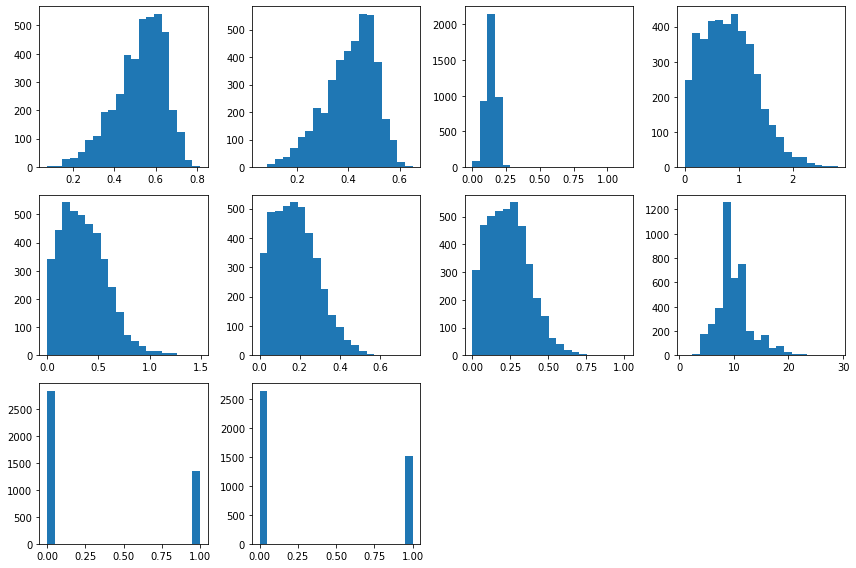

In [6]:
plot_dist(df_data.to_numpy(), 20)

## Step 3 - data pre-processing

1. Separate background covariates (X) from the target (y).
2. Split into training and testing data.
3. Scale the data.

In [7]:
X = df_data.drop(columns=['rings']).to_numpy()
y = df_data['rings'].to_numpy()

In [8]:
print(X.shape)
print(y.shape)

(4177, 9)
(4177,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler_x = MinMaxScaler()

scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)

X_test = scaler_x.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3341, 9)
(3341,)
(836, 9)
(836,)


## Step 4 - train the models

1. Dummy model (sanity check).
2. Linear regression.
3. Decision tree.
4. Random forest.

For each of the above, we do the following:
1. Fit the model on the training data (X and y).
2. Make predictions for the test data (X).
3. Compare obtained predictions to the ground truth (y).

We will use the Mean Squared Error (MSE) metric to evaluate our models' performance.

$$MSE = \frac{1}{n} \sum \limits_{i=1}^{n}(y_i - \hat{y}_i)^2$$

In [10]:
dr = DummyRegressor()
dr.fit(X_train, y_train)

y_pred_test = dr.predict(X_test)

dr_mse_test = mean_squared_error(y_test, y_pred_test)

print(dr_mse_test)

10.034875989137802


In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

lr_mse_test = mean_squared_error(y_test, y_pred_test)

print(lr_mse_test)

4.652027364007254


In [12]:
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)

y_pred_test = dt.predict(X_test)

dt_mse_test = mean_squared_error(y_test, y_pred_test)

print(dt_mse_test)

5.3204004013564115


In [15]:
rf = RandomForestRegressor(max_depth=5)
rf.fit(X_train, y_train.flatten())

y_pred_test = rf.predict(X_test)

rf_mse_test = mean_squared_error(y_test, y_pred_test)

print(rf_mse_test)

4.889626851025618


Compare all obtained results to each other

In [16]:
print(f'Dummy: {dr_mse_test:.3f}')
print(f'LR: {lr_mse_test:.3f}')
print(f'DT: {dt_mse_test:.3f}')
print(f'RF: {rf_mse_test:.3f}')

Dummy: 10.035
LR: 4.652
DT: 5.320
RF: 4.890


## Step 5 (optional) - hyperparameter tuning

1. Manual search via cross-validation.
2. More automated approach with GridSearchCV.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

### Manual

In [24]:
# max_depth, more?
rf_cv = RandomForestRegressor(max_depth=5)
score = cross_val_score(rf_cv, X_train, y_train, cv=5, n_jobs=-1)

print(f'{score.mean():.3f} +- {score.std():.3f}')

0.532 +- 0.015


### GridSearchCV

In [35]:
rf_gs = RandomForestRegressor()
params = {'max_depth': [2, 5, 10, None], 'min_samples_leaf': [1, 2, 5, 10]}
gs_cv = GridSearchCV(rf_gs, cv=5, param_grid=params, n_jobs=-1)

gs_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5, 10]})

In [36]:
gs_cv.best_params_

{'max_depth': None, 'min_samples_leaf': 10}

In [37]:
gs_cv.best_score_

0.5547140606780149

In [38]:
y_pred_test = gs_cv.predict(X_test)

gs_mse_test = mean_squared_error(y_test, y_pred_test)

print(gs_mse_test)

4.584358533902919


In [40]:
print(f'Dummy: {dr_mse_test:.3f}')
print(f'LR: {lr_mse_test:.3f}')
print(f'DT: {dt_mse_test:.3f}')
print(f'RF: {rf_mse_test:.3f}')
print(f'RF tuned: {gs_mse_test:.3f}')

Dummy: 10.035
LR: 4.652
DT: 5.320
RF: 4.890
RF tuned: 4.584
